# Converting Greyscale Images to Binary

The images produced by any microscope are greyscale, meaning each pixel contains a numerical value indicating the intensity of that location.  In an ideal world these values will be nicely distributed, such that all bright pixels corresponding to solid will have high values (i.e, 200-255) while all dark pixels corresponding to void have low values (i.e., 0-50). If this were the case it would be very easy to differentiate or 'segment' the solid and void.

## The Noise Problem

Let's import some of the packages and functions we'll need:

In [1]:
import imageio.v2 as imageio
import porespy as ps
import numpy as np
from matplotlib.pyplot import subplots

Let's generate a fake image and add some noise that is 'easy' to deal with:

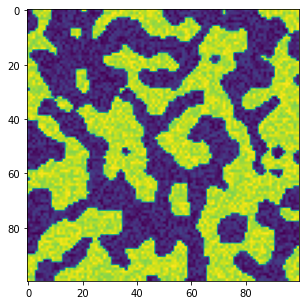

In [2]:
im = ps.generators.blobs(shape=[100, 100])
new_im = (im*0.2) * np.random.rand(*im.shape) + 0.8*im
new_im += (~im*0.2) * np.random.rand(*im.shape)
fig, ax = subplots(figsize=[5, 5])
ax.imshow(new_im);

The above image now contains some noise in each phase, which is more realistic, though as we will see it not close to reality.  Let's look at a histogram of this image:

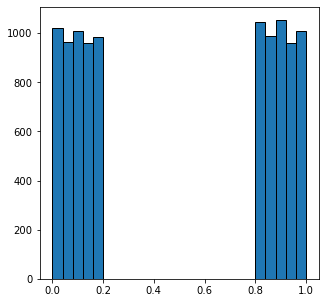

In [3]:
fig, ax = subplots(figsize=[5, 5])
ax.hist(new_im.flatten(), bins=25, edgecolor='k');

We can see above that all pixels with a value less than 0.5 belong to the dark phase, while the other pixels belong to the light phase.  A simple global threshold can reproduce the original image perfectly:

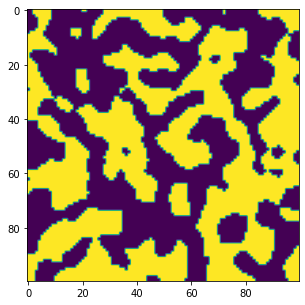

In [4]:
fig, ax = subplots(figsize=[5, 5])
ax.imshow(new_im > 0.5);

Now let's look at a more realistic noise distribution, though still artificially generated:

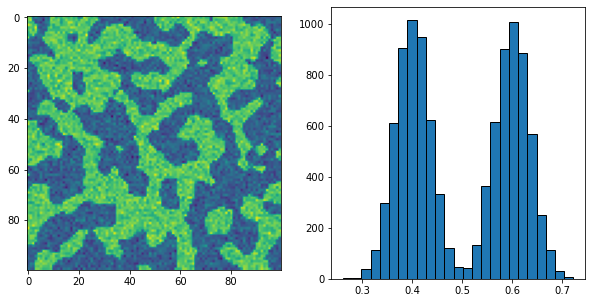

In [5]:
new_im = np.random.normal(loc=.4, scale=0.035, size=im.shape) * im
new_im += np.random.normal(loc=.6, scale=0.035, size=im.shape) * (~im)
fig, ax = subplots(1, 2, figsize=[10, 5])
ax[0].imshow(new_im)
ax[1].hist(new_im.flatten(), bins=25, edgecolor='k');

Now we can see that the noise is much less separated, and in fact the tails of the distributions just touch each other in the middle.  Let's see how the simple threshold we used above would work now:

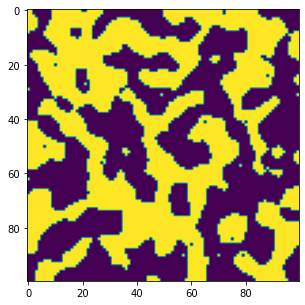

In [6]:
fig, ax = subplots(figsize=[5, 5])
ax.imshow(new_im > 0.5);

Now there are a few pixels in the dark phase which have been identified as bright and vice-versa. Let's take this further but putting more extreme, but more realistic noise:

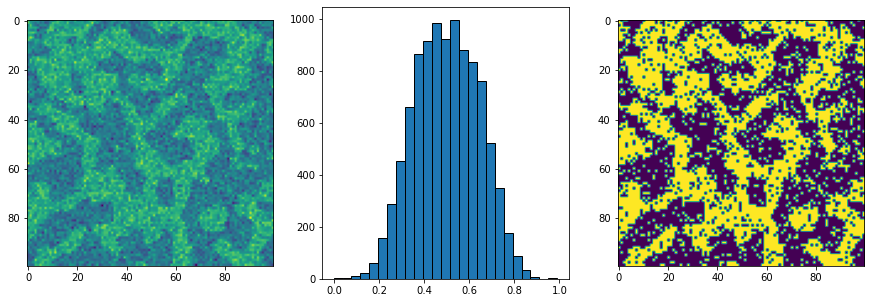

In [7]:
new_im = np.random.normal(loc=.4, scale=0.1, size=im.shape) * im
new_im += np.random.normal(loc=.6, scale=0.1, size=im.shape) * (~im)
fig, ax = subplots(1, 3, figsize=[15, 5])
ax[0].imshow(new_im)
ax[1].hist(new_im.flatten(), bins=25, edgecolor='k')
ax[2].imshow(new_im > 0.5);

In the above case our eyes can differentiate the light and dark phases pretty well, but the histogram is fully merged into one, and the global threshold produces a very problematic result. Just to show this is not an exageration, below is an actual slice of a tomogram taken of an electrospun flow-battery electrode:

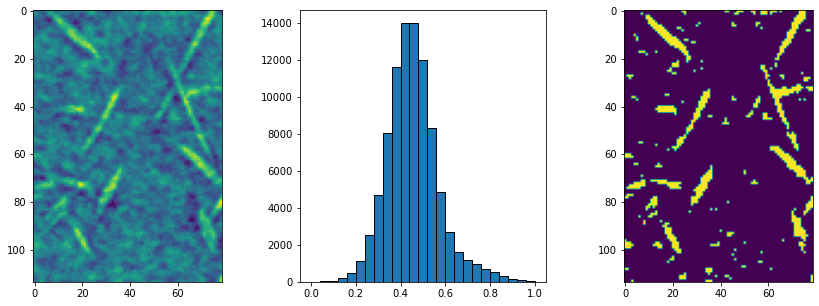

In [8]:
im = imageio.volread('../../docs/_static/images/Sample 1.tif')
im = (im - im.min())/(im.max() - im.min())
fig, ax = subplots(1, 3, figsize=[15, 5])
ax[0].imshow(im[0, ...].T)
ax[1].hist(im.flatten(), bins=25, edgecolor='k')
ax[2].imshow(im[0, ...].T > 0.6);

In the above montage we can see the same effect as the previous artificial case...noisey but usable image, a single histogram, and a segmented image with a lot of falsely labeled pixels.  In the following sections we will explore how to fix this.

## Noise Filtering

The simplest way to describe the noise above is that some pixels which we know lie in the dark region have intensity values brighter than some pixels which we know lie in the bright regions, and vice-versa.  This leads to a false labeling of pixels when a threshold is applied.  The reason that our eyes can still see dark and light regions, depsite the noise, is that the *majority* of pixels in the dark region are darker than the bright regions, and vice-versa.  Our eyes can do some sort of averaging on the data to discard or correct for the spurious intensity pixels.  

> We just need to find a way to get the computer to recognize this!

### Non-Edge Preserving Filters

The most obvious way to fix this is to replace each pixel with a value that is the average of the pixels around it. We could do a straight-up averaging, or some weighting like a gaussian blur:

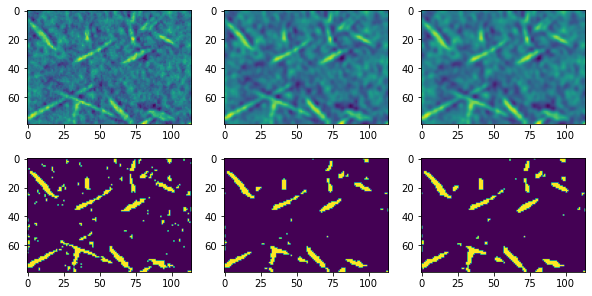

In [9]:
import scipy.ndimage as spim
im = imageio.volread('../../docs/_static/images/Sample 1.tif')
im = (im - im.min())/(im.max() - im.min())
im = im[0, ...]
im1 = spim.uniform_filter(im, size=3)
im1 = (im1 - im1.min())/(im1.max() - im1.min())
im2 = spim.gaussian_filter(im, sigma=1)
im2 = (im2 - im2.min())/(im2.max() - im2.min())
fig, ax = subplots(2, 3, figsize=[10, 5])
ax[0][0].imshow(im)
ax[0][1].imshow(im1)
ax[0][2].imshow(im2)
ax[1][0].imshow(im > 0.6)
ax[1][1].imshow(im1 > 0.6)
ax[1][2].imshow(im2 > 0.6);

The above results are not too bad, but as noted in the title of this subsection, these filters do not preserve edges.  Consider the following artificial case:

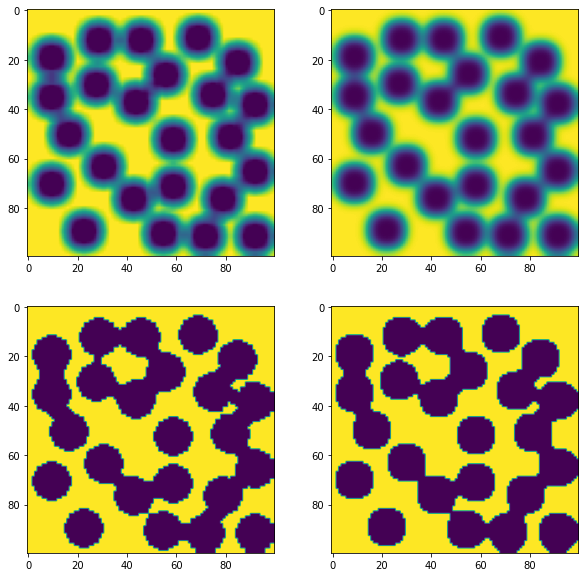

In [10]:
im = ~ps.generators.random_spheres([100, 100], r=8)*1.0
im1 = spim.uniform_filter(im, size=6)
im2 = spim.gaussian_filter(im, sigma=2)
fig, ax = subplots(2, 2, figsize=[10, 10])
ax[0][0].imshow(im1)
ax[0][1].imshow(im2)
ax[1][0].imshow(im1 > im1.mean())
ax[1][1].imshow(im2 > im2.mean());

In the bottom row above it can be seen that the original image is not recovered upon applying the threshold. The reason for this is that the filters merged information from the entire neighborhood without regard for whether those values were high or low (other than the usual weighting). This means that edges are blurred and some information is lost.  Although these filters can do a passable job if the noise is not too bad, in the next section we will look at some fancier filters for this job.

### Edge Preserving Filters

The ability to preserve edges is quite helpful when trying to segment solid and void, which have strong edges in reality.  The simplest edge preserving filter is the median filter which instead of an average takes the middle value of the neighborhood.  This works because a pixel on an edge will be surrounded by many pixels with similar values, and a smaller number of dissimilar values, hence preserving the edge.  The need for a powerful edge preserving filter has inspired the development of several (much) more complicated algorithms, including the `non-local means`, which is very effective as shown below.

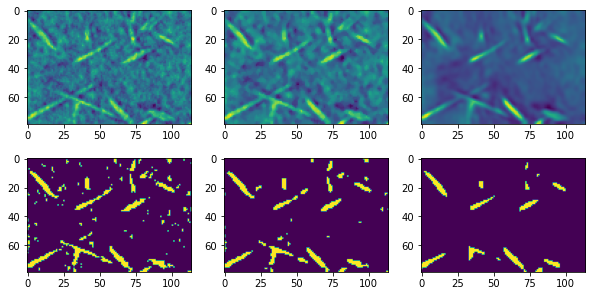

In [11]:
from skimage.restoration import non_local_means, estimate_sigma
im = imageio.volread('../../docs/_static/images/Sample 1.tif')
im = (im - im.min())/(im.max() - im.min())
im = im[0, ...]
im1 = spim.median_filter(im, size=3)
im1 = (im1 - im1.min())/(im1.max() - im1.min())
s = estimate_sigma(im)
im2 = non_local_means.denoise_nl_means(im)
im2 = (im2 - im2.min())/(im2.max() - im2.min())
fig, ax = subplots(2, 3, figsize=[10, 5])
ax[0][0].imshow(im)
ax[0][1].imshow(im1)
ax[0][2].imshow(im2)
ax[1][0].imshow(im > 0.6)
ax[1][1].imshow(im1 > 0.6)
ax[1][2].imshow(im2 > 0.5);

In the above montage the middle image shows the median filter and the edges are visibly less blurred than the gaussian and uniform filters used in the previous section.  The result after threshold is also better.  The right column above shows the non-local means filter and the result is clearly superior.  This was done without even attempting to optimize the various adjustable parameters, which will be explored below.

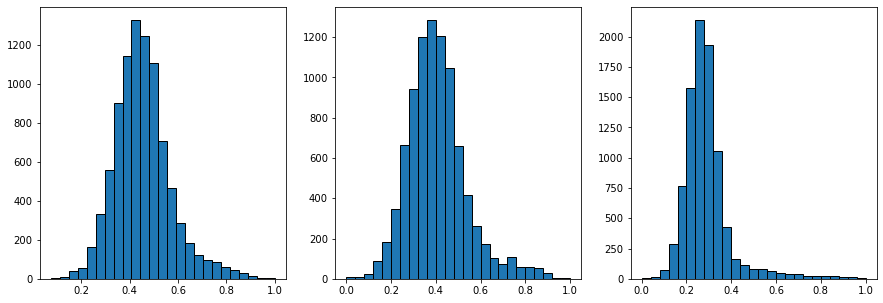

In [12]:
fig, ax = subplots(1, 3, figsize=[15, 5])
ax[0].hist(im.flatten(), bins=25, edgecolor='k')
ax[1].hist(im1.flatten(), bins=25, edgecolor='k')
ax[2].hist(im2.flatten(), bins=25, edgecolor='k');

The three histograms above show the distribution of pixel values before filtering, after the median filter, and after the non-local means filter.  The long tail on the righthand side of the non-local means histogram is bright pixels which have now been separated from the dark ones..thought the two histograms will overlap quite a bit.  Note that the solid volume fraction of the material is quite low so there are not a lot of bright pixels, hence the histogram for the bright pixels is not very tall.

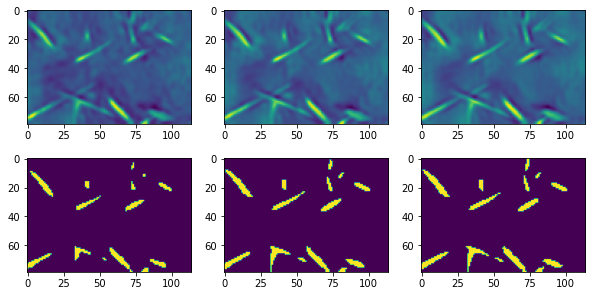

In [13]:
im = imageio.volread('../../docs/_static/images/Sample 1.tif')
im = (im - im.min())/(im.max() - im.min())
im = im[0, ...]
s = estimate_sigma(im)

kw = {
    'patch_size': 7,
    'patch_distance': 11,
    'h': 0.1,
}
im1 = non_local_means.denoise_nl_means(im, sigma=s, **kw)
im1 = (im1 - im1.min())/(im1.max() - im1.min())

kw = {
    'patch_size': 7,
    'patch_distance': 7,
    'h': 0.1,
}
im2 = non_local_means.denoise_nl_means(im, sigma=s, **kw)
im2 = (im2 - im2.min())/(im2.max() - im2.min())

kw = {
    'patch_size': 9,
    'patch_distance': 7,
    'h': 0.1,
}
im3 = non_local_means.denoise_nl_means(im, sigma=s, **kw)
im3 = (im3 - im3.min())/(im3.max() - im3.min())

fig, ax = subplots(2, 3, figsize=[10, 5])
ax[0][0].imshow(im1)
ax[0][1].imshow(im2)
ax[0][2].imshow(im3)
ax[1][0].imshow(im1 > 0.5)
ax[1][1].imshow(im2 > 0.5)
ax[1][2].imshow(im3 > 0.5);

The rightmost figure above is probably the most smooth in terms of noise removal and shows the cleanest segmentation, though only barely better.

### Applying Non-Local Means to a Stack

The non-local means filter is *very slow*, and is exponentially slower when applied to a 3D image.  Luckily, this filter can be applied to each layer independently of the other layers, if done along the same axis as the slicing was done during the experiment.  PoreSpy implements a parallelized version of this filter which basically just processes the layers on each available core.  Usage of this function is outlined [here](https://porespy.org/examples/filters/reference/nl_means_layered.html).